In [1]:
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

In [10]:
transform = np.array([
    [1, 0, 3],
    [0, 1, 0],
    [0, 0, 1],
])
ndimage.map_coordinates(x, [[1, 1], [2, 2]])

array([3, 3])

Okay, so `map_coordinates()` is basically a float-supporting fancy indexing function

## Simplify the slicing process: keep only the necessary parts

In [144]:
from slicereg.repos.atlas_repo import BrainglobeAtlasRepo
from slicereg.models.transforms import Plane3D
from slicereg.models.section import Section
from slicereg.models.atlas import Atlas
from slicereg.io.ome_tiff import OmeTiffReader
import numpy as np
import matplotlib.pyplot as plt


In [4]:
atlas = BrainglobeAtlasRepo().load_atlas(resolution=100)
vol = atlas.volume
vol.shape, vol.size

((132, 80, 114), 1203840)

   1203840
  77045760
1203840000

TiffFrame 2: missing required tags


(4198, 2816)

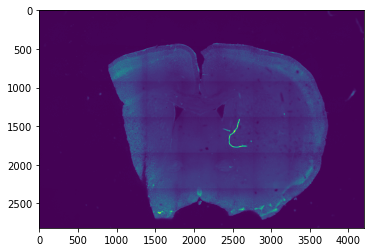

In [13]:
image = OmeTiffReader().read("../data/RA_10X_scans/MeA/S1_07032020.ome.tiff")
plt.imshow(image.channels[0]);
image.width, image.height

In [7]:
section = Section(image)
section

Section(image=ImageData(pixel_resolution_um=0.36133041860128995), plane_2d=Plane2D(x=0.0, y=0.0, theta=0.0), plane_3d=Plane3D(x=0.0, y=0.0, z=0.0, rx=0.0, ry=0.0, rz=0.0), thickness_um=16.0, id=UUID('b9a35c67-1760-4a65-af3a-580b155beaa8'))

In [11]:
#!pip install line_profiler  # if fails,  install from wheel from https://www.lfd.uci.edu/~gohlke/pythonlibs/#line_profiler
%load_ext line_profiler

In [18]:
from functools import lru_cache

array([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
       [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [103]:
width, height = section.image.width, section.image.height
inds = inds_homog(height=height, width=width)
res = 1 / atlas.resolution_um
(np.diag([res, res, res, 1.]) @ section.affine_transform @ inds)[:, :6]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.03, 0.06, 0.08, 0.11, 0.14],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]])

In [102]:
width, height = section.image.width, section.image.height
inds = inds_homog(height=height, width=width)
    
coords = section.affine_transform @ inds
coords[:3, :] / atlas.resolution_um


array([[  0.  ,   0.  ,   0.  , ..., 116.15, 116.15, 116.15],
       [  0.  ,   0.03,   0.06, ...,  77.85,  77.88,  77.91],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]])

In [119]:
2**16

65536

In [211]:
import numexpr as ne
from numba import njit, prange

In [218]:
@lru_cache()
def inds_homog(height, width):
    grid = np.mgrid[:width, :height, :1].reshape(-1, width*height)
    ones = np.ones(width*height, dtype=int)
    full = np.vstack((grid, ones)).astype(float)
    return full


@njit(parallel=True, fastmath=True)
def _register(inds, volume, transform):
    atlas_coords = transform @ inds
    atlas_coords = atlas_coords[:3, :]
    
    vals = np.empty(atlas_coords.shape[1])
    for ind in prange(atlas_coords.shape[1]):
        vals[ind] = volume[int(atlas_coords[0, ind]), int(atlas_coords[1, ind]), int(atlas_coords[2, ind])]
    return vals


def register(section: Section, atlas: Atlas):
    width, height = section.image.width, section.image.height
    inds = inds_homog(height=height, width=width)
    res = 1 / atlas.resolution_um
    scale_mat = np.diag([res, res, res, 1.])
    brightness_3d = _register(inds, volume=atlas.volume, transform=scale_mat @ section.affine_transform)
    registered_slice = brightness_3d.reshape(width, height)
    return registered_slice

s = section.translate(dz=4000).rotate(dx=70)
%timeit atlas_slice = register(s, atlas)
# plt.imshow(atlas_slice);

227 ms ± 6.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [133]:
400 / 16

25.0

You should consider upgrading via the 'D:\ProgrammingProjects\slicereg\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


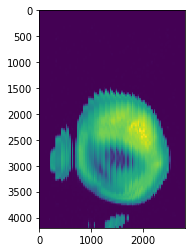

In [213]:
atlas_slice = register(s, atlas)
plt.imshow(atlas_slice);

In [220]:
%lprun -f register register(s, atlas)

Timer unit: 1e-07 s

Total time: 0.210452 s
File: <ipython-input-218-071df4a2b270>
Function: register at line 22

Line #      Hits         Time  Per Hit   % Time  Line Contents
    22                                           def register(section: Section, atlas: Atlas):
    23         1        151.0    151.0      0.0      width, height = section.image.width, section.image.height
    24         1         51.0     51.0      0.0      inds = inds_homog(height=height, width=width)
    25         1         46.0     46.0      0.0      res = 1 / atlas.resolution_um
    26         1        433.0    433.0      0.0      scale_mat = np.diag([res, res, res, 1.])
    27         1    2103755.0 2103755.0    100.0      brightness_3d = _register(inds, volume=atlas.volume, transform=scale_mat @ section.affine_transform)
    28         1         79.0     79.0      0.0      registered_slice = brightness_3d.reshape(width, height)
    29         1          7.0      7.0      0.0      return registered_slice

In [216]:
section.image.pixel_resolution_um

0.36133041860128995